# 1a

Assuming the RVC is placed in the top left corner, the logic governing it would be something like this:

FOR ROW in GRID:
  
&emsp;IF ROW_NUMBER is EVEN:  
&emsp;&emsp;REPEAT N TIMES:  
&emsp;&emsp;&emsp;CLEAN, MOVE RIGHT
  
&emsp;ELSE:  
&emsp;&emsp;REPEAT N TIMES:  
&emsp;&emsp;&emsp;CLEAN, MOVE LEFT  

This is easy enough to implement using for loops. We will also need some function to plot how the floor looks at various points during the cleaning process.




In [42]:
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.animation as animation

# Dunno why, but this is necessary for the animation
from IPython.display import HTML

import numpy as np

In [43]:
'''ANIMATION TEST'''

fig, ax = plt.subplots()
rng = np.random.default_rng(19680801)
data = np.array([20, 20, 20, 20])
x = np.array([1, 2, 3, 4])

artists = []
bar_colors = ['tab:blue', 'tab:red', 'tab:green', 'tab:purple']
for i in range(20):
    data += rng.integers(low=0, high=10, size=data.shape)
    container = ax.barh(x, data, color=bar_colors)
    artists.append(container)


ani = animation.ArtistAnimation(fig=fig, artists=artists, interval=400)
plt.close(fig)

HTML(ani.to_jshtml())




# 1b

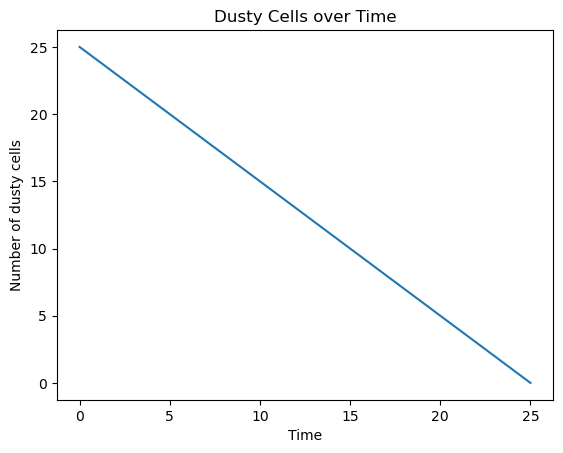

In [44]:
'''
We'll refer to the NxN matrices representing the state of the room as 'grids'.

Let's use the following convention for the entries in the grids:
-1: Clean tile
0: Dirty tile
1: Table
2: Chair
3: Robot
'''

# Set colors
clean_tile_color = "white"
dusty_tile_color = "#cfebe8"
obstacle_color = "red"
robot_color = "orange"
grid_line_color = "#5fa2bb"

# Define colormap
cmap = colors.ListedColormap([clean_tile_color, dusty_tile_color, obstacle_color, robot_color])
bounds = [-1.5, -0.5, 0.5, 2.5, 3.5]
# Map numerical values of tiles to colormap
cmap_norm = colors.BoundaryNorm(bounds, cmap.N)

'''
display_grid() takes in a grid and a title and plots the grid in a plot with the desired title.

This will be used to display the state of the room at various points throughout the cleaning process.
'''
def display_grid(grid, title_text):
    # Initialize plot (by using plt.subplots() we get an 'ax' object that we can manipulate to draw the grid)
    fig, ax = plt.subplots()

    # Add grid lines
    ax.grid(color=grid_line_color)

    # Adjust grid line positions
    ax.set_xticks(np.arange(-0.5, len(grid), 1))
    ax.set_yticks(np.arange(-0.5, len(grid), 1))

    # Hide x and y labels
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # Set title
    ax.set_title(title_text)

    # Show plot
    ax.imshow(grid, cmap=cmap, norm=cmap_norm)

''' 
The ordered_cleaning() function implements the cleaning logic from 1a and animates the process.

It takes in the grid size (N) and returns an animation.
'''
def ordered_cleaning(N):
    # Initialize grid (all tiles dirty)
    grid = np.zeros((N,N))
    
    # Initialize a plot for animation
    fig, ax = plt.subplots()

    # Add grid lines
    ax.grid(color=grid_line_color)

    # Adjust grid line positions
    ax.set_xticks(np.arange(-0.5, N, 1))
    ax.set_yticks(np.arange(-0.5, N, 1))

    # Hide x and y labels
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # Store artists for the animation (objects containing all the info of our plots)
    artists = []

    # Keep track of the number of dusty cells
    dusty_cells_over_time = [N*N]

    # # Plot grid at the start
    # display_grid(grid, "The room at the start of the cleaning process")

    # Loop through the rows
    for i in range(len(grid)):
        # Loop through the columns
        for j in range(len(grid[i])):
            # If the row is even, move left to right
            if i%2 == 0:
                grid[i][j] = 3
            # Otherwise, move right to left
            else:
                grid[i][-1 - j] = 3
            artist = ax.imshow(grid, cmap=cmap, norm=cmap_norm, animated=True)
            artists.append([artist]) # For some reason the ArtistAnimation method wants the artists to be wrapped in lists? Don't ask me why
            
            # Clean the tile the robot is currently on
            for k in range(len(grid)):
                for l in range(len(grid[k])):
                    if grid[k][l] == 3:
                        grid[k][l] = -1

            # # If we are in the middle of the cleaning process, plot the grid
            # if i == N // 2 and j == 0:
            #     display_grid(grid, "The room in the middle of the cleaning process")

            # Reduce the number of dusty cells and store the result
            dusty_cells_over_time.append(dusty_cells_over_time[-1] - 1)

    # # Display the grid at the end
    # display_grid(grid, "The room at the end of the cleaning process")

    # Animate using Artist Animation:
    ani = animation.ArtistAnimation(fig, artists, interval=500)
    # If this line is not added, the final frame is plotted seperately for some reason
    plt.close(fig)
    # To get inline animation in jupyter
    return HTML(ani.to_jshtml()), dusty_cells_over_time


ani, dusty_cells_over_time = ordered_cleaning(5)

# Plot amount of dust over time
plt.figure()
plt.plot(dusty_cells_over_time)
plt.xlabel('Time')
plt.ylabel('Number of dusty cells')
plt.title('Dusty Cells over Time')
plt.show()

ani



# 1c

There isn't much to discuss here, as the robot moves in a very predictable pattern without any obstacles. The results from the code completely match my expectations.

# 2a

To implement the random movement, we'll keep track of the RVCs position and the tiles it can access. We'll then choose one of the accessible tiles at random, move to it, and clean it.

The process repeats until all tiles have been cleaned.

# 2b

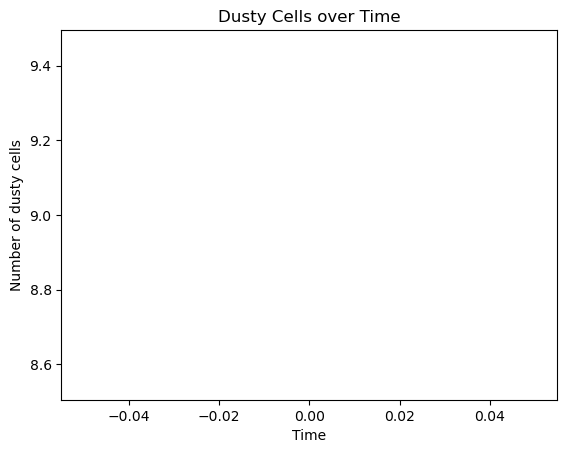

In [46]:
''' 
We can reuse much of the code from 1b, with some modifications to the cleaning function.
'''

'''
This is a helper function to check if our grid contains a certain value. 

It will be used to check if all tiles have been cleaned.
'''
def contains_value(grid, val):
    for row in grid:
        for entry in row:
            if entry == val:
                return True
    
    return False


def random_cleaning(N):
    # Initialize grid (all tiles dirty)
    grid = np.zeros((N,N))

    # Initialize RVC position (in the center):
    RVC_position = [N // 2, N // 2]
    grid[N // 2][N // 2] = 3
    
    # Initialize a plot for animation
    fig, ax = plt.subplots()

    # Add grid lines
    ax.grid(color=grid_line_color)

    # Adjust grid line positions
    ax.set_xticks(np.arange(-0.5, N, 1))
    ax.set_yticks(np.arange(-0.5, N, 1))

    # Hide x and y labels
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # Store artists for the animation (objects containing all the info of our plots)
    artists = []

    # Keep track of the number of dusty cells
    dusty_cells_over_time = [N*N]



    # # Plot grid at the start
    # display_grid(grid, "The room at the start of the cleaning process")

    # The loop runs until all tiles have been cleaned:
    while(contains_value(grid, 0)):
        # Save artist for the animation
        artist = ax.imshow(grid, cmap=cmap, norm=cmap_norm, animated=True)
        artists.append([artist])

        # Find tiles accessible by the RVC (relative to its position):
        accesible_tiles = []
        for i in range(-1, 2):
            for j in range(-1, 2):
                # Constraints
                is_not_current_position = not (i == 0 and j == 0)
                is_within_bounds_x = 0 <= RVC_position[0] + i < N
                is_within_bounds_y = 0 <= RVC_position[1] + j < N

                if is_not_current_position and is_within_bounds_x and is_within_bounds_y:
                    accesible_tiles.append([i, j])

        # Choose an accesible tile to move to
        tile_to_move_to = accesible_tiles[np.random.randint(0, len(accesible_tiles))]

        


        # Clean the current tile and go there
        grid[RVC_position[0]][RVC_position[1]] = -1

        RVC_position[0] += tile_to_move_to[0]
        RVC_position[1] += tile_to_move_to[1]

        grid[RVC_position[0]][RVC_position[1]] = 3

    # Save the final artist for the animation
    artist = ax.imshow(grid, cmap=cmap, norm=cmap_norm, animated=True)
    artists.append([artist])

    # # Display the grid at the end
    # display_grid(grid, "The room at the end of the cleaning process")

    # Animate using Artist Animation:
    ani = animation.ArtistAnimation(fig, artists, interval=500)
    # If this line is not added, the final frame is plotted seperately for some reason
    plt.close(fig)
    # To get inline animation in jupyter
    return HTML(ani.to_jshtml()), dusty_cells_over_time

ani, dusty_cells_over_time = random_cleaning(3)

# Plot amount of dust over time
plt.figure()
plt.plot(dusty_cells_over_time)
plt.xlabel('Time')
plt.ylabel('Number of dusty cells')
plt.title('Dusty Cells over Time')
plt.show()

ani




